# Green Vegetation Temporal Dynamics: Monitoring and Analysis using NDVI and Fractional Cover TERN rasters (Part 2)

In this tutorial, we will explore how to monitor and analyse the temporal dynamics of green vegetation. To monitor these temporal dynamics we will use the Normalize Difference Vegetation Index (NDVI). To analyse the causes of the green vegetation temporal dynamics we will explore the changes in the Green Cover Fraction over time. All the datasets used in this tutorial are products of TERN's Landscapes Assessment (AusCover) program. 

We will compute NDVIs from composited seasonal Surface Reflectance images (4 seasons for year). Composite seasonal surface reflectance datasets were created from full time series of Landsat TM/ETM+ imagery. The imagery had been composited over a season to produce new imagery that is representative of the period. In this process, techniques that reduce contamination by cloud and other problems were used. In the final sections of this tutorial, we will investigate the causes of temporal NDVI change in the area of most noticeable greening. To do so, a time series of the green fraction is plotted and examined. The green fraction is one of the bands in the fractional cover product. 

This tutorial is based on Peter Scarth's *\"Simple Change Detection in Raster using TERN web services and Google Earth Engine\"* tutorial. Although it (more or less) follows Dr. Scarth's tutorial steps, both tutorials differ in some of their contents. In addition, Dr. Scarth's tutorial in implemented in python, while we will use R. 

Due to its length, this tutorial has been divided into two parts. *Part 1* describes how to perform the necessary steps required to obtain, manipulate, and display rasters in R using TERN's surface reflectance datasets as an example (see below). More detailed descriptions and explanations of these (and many other) raster operations in R are provided in TERN's "Using Raster Data in R" tutorial. *Part 2* conducts the bulk of the computation and analysis of the temporal dynamics of green vegetation, which includes (among others) operations to subset, combine, and display rasters. It also makes use of most of the steps presented in Part 1, but in Part 2 these steps are included in a function. Specifically, the two parts of this sutorial cover the following aspects (in bold Part 2, which is covered in this document):


1. INTRODUCTORY STEPS (getting acquainted with using raster files in R):
  * Download files from remote systems.
  * Open raster files.
  * Explore raster files.
  * Subset (i.e. crop) raster files.
  * Combine raster files into a multi-layered raster object.
  * Visualise a multi-layer raster object.
  * Re-project a raster object.
  * Open a remote map to find our bearings.

**2. NORMALIZED DIFFERENCE VEGETATION INDEX (NDVI) CHANGE ANALYSIS:**

  * Explore an Area where NDVI Change might have occurred
  * Conduct Tasks in the 'Introductory Steps' part (i.e. Download, Read, Subset, and Combine the Landsat Surface Reflectance Data) by:
    * Creating a function to perform these tasks.
    * Call this function on datasets 10 years apart: 2007 and 2017.
  * Compute NDVIs: Raw & Normalised
  * NDVI Change Analysis: Numerical & Visualisation
  * NDVI Time Series of Green Visualisation
  * Explore NDVI Change in an Area of Notable Greening.

For conciseness the messages returned by R are not displayed (i.e. only the results). 

The images and plots in this report can appear small at times. However, they look fine on a computer monitor when the code is run in a computer.



## NORMALIZED DIFFERENCE VEGETATION INDEX (NDVI) CHANGE ANALYSIS

In this section we will explore the change in NDVI in an area west of Tara where Coal Seam Gas development has been happening in recent years. NDVI can be used to estimate the density of green vegetation on a patch of land. It is derived from remote sensing data, typically a space platform. Chlorophyll, the pigment in plant leaves, strongly absorbs red and blue light. Leaves, on the other hand, strongly reflect near-infrared light (NIR) and green light (this is why vegetation looks green to our eyes). NDVI takes advantage of this difference in behaviour for different light wavelengths by green vegetation, combining measurements at different wavelengths in  this formula: NDVI = (NIR-Red)/(NIR+Red). NDVI ranges from -1 to 1. With different values indicating different situations:

* _Values close to '+1' (0.8-0.9):_ Very high density of green leaves.
* _Low values:_ Low vegetation.
* _Very low values (e.g. 0.2):_ Nearly bare soils. 
* _Values close to '0':_ Practically no vegetation (e.g. densely populated urban areas). 
* _Very low positive to slightly negative values:_ Free standing water (e.g. oceans, seas, lakes, rivers), which have rather low reflectance in both spectral bands.
* _Values close to '-1':_ likely to represent atmospheric disturbance or some specific materials. 

Generally, to investigate NDVI change over time an atmospheric correction needs to be performed. The data that we use in this workshop has already been corrected to reduce contamination by cloud and other problems.


### Preparation: Getting ready

We start by loading the required libraries, setting up a working directory, and cleaning up memory. 


In [1]:
# Load  Libraries
# ===============

library(dplyr)
library(reshape2)
library(stringr)
library(XML)  # Used to download latest Green Cover Fraction Dataset (see below)

library(RColorBrewer)
library(ggplot2)
library(gridExtra)
library(RStoolbox)

library(sp)

library(rgdal)
library(geojsonio)
library(raster)
library(rasterVis)

##library(RgoogleMaps)
# NOTE: When installing ggmap you might need to install the development version,
# rather than just the CRAN version (see bellow how to do it)
#library(devtools)
#devtools::install_github("dkahle/ggmap", force=TRUE)
library(ggmap)

#library(maps)
#library(mapdata)
#library(maptools)


# Set Data Path (TERN AusCover data repository)
# =============================================
data.path = "http://qld.auscover.org.au/public/data/landsat/surface_reflectance/aus"


# Optional Steps (remove comments to run them)
# ==============

# Setting up my Current Working Directory
# ---------------------------------------
#getwd()
#my.CWDir = "C:/Users/uqbblanc/Documents/TERN/CWDir"
#setwd(my.CWDir)
#getwd()

# Clean up Memory
# ---------------
#rm(list=ls())
#list.files()

Warning message:
"package 'dplyr' was built under R version 3.5.3"
Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Warning message:
"package 'XML' was built under R version 3.5.2"
Attaching package: 'gridExtra'

The following object is masked from 'package:dplyr':

    combine

Warning message:
"package 'RStoolbox' was built under R version 3.5.3"Warning message:
"package 'rgdal' was built under R version 3.5.3"rgdal: version: 1.4-3, (SVN revision 828)
 Geospatial Data Abstraction Library extensions to R successfully loaded
 Loaded GDAL runtime: GDAL 2.2.3, released 2017/11/20
 Path to GDAL shared files: C:/Users/uqbblanc/Documents/R/R-3.5.1/library/rgdal/gdal
 GDAL binary built with GEOS: TRUE 
 Loaded PROJ.4 runtime: Rel. 4.9.3, 15 August 2016, [PJ_VERSION: 493]
 Path to PROJ.4 shared files: C:/Users/uqbblanc/Documents/R/R-3.5.1/library/


### Explore an Area where NDVI Change might have occurred

We import and display a Stamen map to explore the area that we will be working with (West of Tara). The first attempt, using the extent of this area, leads to too detailed map. We add a plot where we zoom out by 2 degrees and now we can identify a nearby location (Dalby).


class       : Extent 
xmin        : 150.3727 
xmax        : 150.4963 
ymin        : -27.0767 
ymax        : -26.9819 

Map tiles by Stamen Design, under CC BY 3.0. Data by OpenStreetMap, under ODbL.
Map tiles by Stamen Design, under CC BY 3.0. Data by OpenStreetMap, under ODbL.
56 tiles needed, this may take a while (try a smaller zoom).


class       : SpatialPolygons 
features    : 1 
extent      : 150.3727, 150.4963, -27.0767, -26.9819  (xmin, xmax, ymin, ymax)
coord. ref. : NA 

class       : SpatialPolygons 
features    : 1 
extent      : 150.3727, 150.4963, -27.0767, -26.9819  (xmin, xmax, ymin, ymax)
coord. ref. : +init=epsg:4326 +proj=longlat +datum=WGS84 +no_defs +ellps=WGS84 +towgs84=0,0,0 

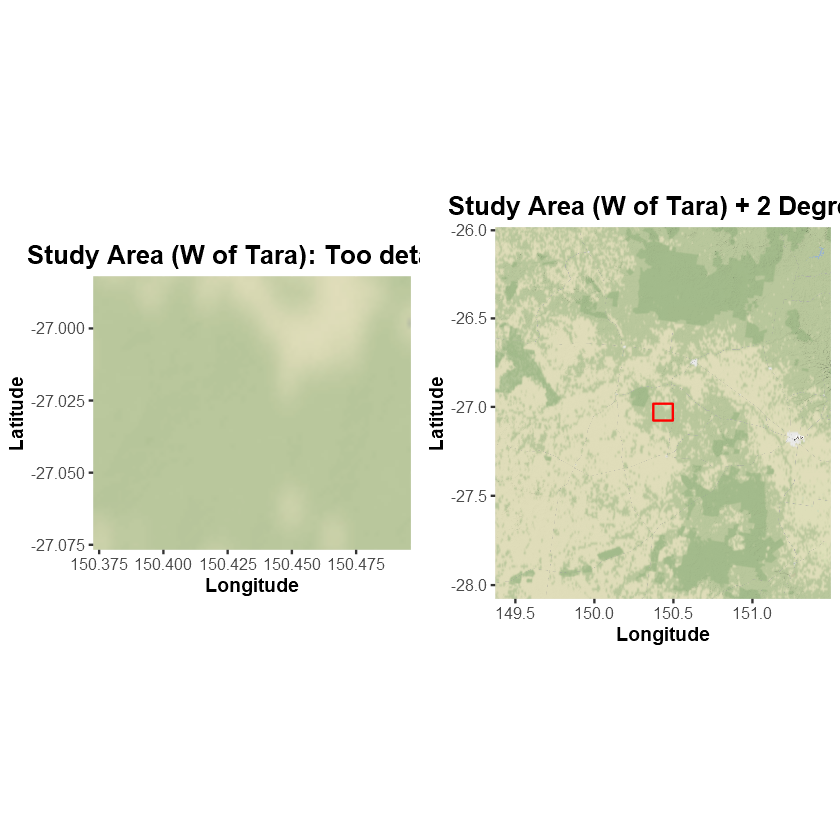

In [2]:
# Define the Extent of the Area to Explore
# ----------------------------------------
WofTara.extent = extent(150.3727, 150.4963, -27.0767, -26.9819)
WofTara.extent

# Get Map with for West of Tara Extent 
# ------------------------------------
WofTara.StamenMap = get_stamenmap(WofTara.extent[c(1,3,2,4)], maptype="terrain")

# Create Plot of the Map
# ----------------------
WofTara.Map.P1 = 
ggmap(WofTara.StamenMap) + labs(title= "Study Area (W of Tara): Too detailed", x="Longitude", y="Latitude") +
theme(plot.title = element_text(hjust = 0.5, size=15, face="bold"), 
      axis.title = element_text(size=11, face="bold"), axis.text=element_text(size=9) )
#WofTara.Map.P1  # Plot individually for a bigger image

# Zoom out by 2 degrees & Create New Plot
# ---------------------------------------
 # Download Map with new wider extent
WofTaraPlus2.StamenMap = get_stamenmap((WofTara.extent+2)[c(1,3,2,4)], maptype="terrain")
 # Create Plot for new wider map
WofTaraPlus2.Map.P2 = 
ggmap(WofTaraPlus2.StamenMap) + labs(title= "Study Area (W of Tara) + 2 Degrees", x="Longitude", y="Latitude") +
theme(plot.title = element_text(hjust = 0.5, size=15, face="bold"), 
      axis.title = element_text(size=11, face="bold"), axis.text=element_text(size=9) )
 # Create Polygon with Original Extent and Add it to the Plot
WofTara.SP = as(WofTara.extent, "SpatialPolygons")
WofTara.SP  # Has no CRS
proj4string(WofTara.SP) = CRS("+init=epsg:4326") # Add CRS
WofTara.SP
 # Add Polygon to the Plot
WofTaraPlus2.Map.P2 = WofTaraPlus2.Map.P2 + geom_polygon(data=WofTara.SP, aes(x=long, y=lat), color="red", alpha=0)
#WofTaraPlus2.Map.P2  # Plot individually for a bigger image

# Show Both Plots 
# ----------------
grid.arrange(WofTara.Map.P1, WofTaraPlus2.Map.P2, nrow=1)


### Create a function to Download, Read, Subset, and Combine the Landsat Surface Reflectance Data.

This function includes many of the steps in the **INTRODUCTORY STEPS** section. Specifically the function perform these tasks: 

* Download the data file
* Load the data file required bands
* Subset the RasterLayer objects
* Replaced values < 0 with the Missing Data code (Not really required in this example)
* Create a multi-layered RasterBrick object
* Return the multi-layered RasterBrick object

The function takes the following arguments:

* `data.fpn`: Data file path and name
* ` dl.fn`: Name for the downloaded file
* `rB.extent`: RasterBrick extent
* `rB.crs`: RasterBrick coordinates reference system

There are a number of `print` commands within the function 'commented out'. These commands are not required for the correct functioning of the function. However, they have been included because they might make it easier to understand what the function is doing. To investigate further what the function is doing at each step simply remove the comment (`#`) symbol in front of the relevant `print` command.


In [3]:

get.B3B4B5.rB.f = function(data.fpn, dl.fn, rB.extent, rB.crs){

	# Download the data file
	# ======================	
	download.file(url=data.fpn, destfile=dl.fn, method='auto')
	#print(list.files())

	
	# Load the data file required bands
	# =================================
	LSSR.Band3.rL = raster(dl.fn, band=3)
	#print(LSSR.Band3.rL)
	LSSR.Band4.rL = raster(dl.fn, band=4)
	#print(LSSR.Band4.rL)
	LSSR.Band5.rL = raster(dl.fn, band=5)
	#print(LSSR.Band5.rL)

	
	# Subset Rasters
	# ==============	

	# Project Extent to a CRS=EPSG:3577
	# ---------------------------------
	#print(rB.extent)
	# Create a Polygon from Extent, Reproject the Poloygon and use its extension
	rB.extent.GeoCoord.SP = as(rB.extent, "SpatialPolygons")
	#print(rB.extent.GeoCoord.SP)  # Has no CRS
	proj4string(rB.extent.GeoCoord.SP) = CRS("+init=epsg:4326")
	#print(rB.extent.GeoCoord.SP)
	rB.extent.EPSG3577.SP = spTransform(rB.extent.GeoCoord.SP, CRS("+init=epsg:3577"))
	#print(rB.extent.EPSG3577.SP)
	rB.extent.EPSG3577 = extent(rB.extent.EPSG3577.SP)
	#print(rB.extent.EPSG3577)

	# Crop (i.e. subset) the raster layers to our area of interest
	# ---------------------------------
	LSSR.Subset.Band3.rL = crop(LSSR.Band3.rL, rB.extent.EPSG3577)
	#print(LSSR.Subset.Band3.rL)
	LSSR.Subset.Band4.rL = crop(LSSR.Band4.rL, rB.extent.EPSG3577)
	#print(LSSR.Subset.Band4.rL)
	LSSR.Subset.Band5.rL = crop(LSSR.Band5.rL, rB.extent.EPSG3577)
	#print(LSSR.Subset.Band5.rL)
	
	# Replace values < 0 with NAs
	# ===========================
	 # Band 3: Red
	 # ------------
	LSSR.Subset.Band3.rL[LSSR.Subset.Band3.rL < 0] = NA
	#print(LSSR.Subset.Band3.rL)
	#print(freq(is.na(LSSR.Subset.Band3.rL)))
	#print(freq(is.na(LSSR.Subset.Band3.rL))/ncell(LSSR.Subset.Band3.rL))
	 # Band 4: NIR
	 # ------------
	LSSR.Subset.Band4.rL[LSSR.Subset.Band4.rL < 0] = NA
	#print(LSSR.Subset.Band4.rL)
	#print(freq(is.na(LSSR.Subset.Band4.rL)))
	#print(freq(is.na(LSSR.Subset.Band4.rL))/ncell(LSSR.Subset.Band4.rL))
	 # Band 5: SWIR
	 # ------------
	LSSR.Subset.Band5.rL[LSSR.Subset.Band5.rL < 0] = NA
	#print(LSSR.Subset.Band5.rL)
	#print(freq(is.na(LSSR.Subset.Band5.rL)))
	#print(freq(is.na(LSSR.Subset.Band5.rL))/ncell(LSSR.Subset.Band5.rL))

	
	# Create a multi-layered RasterBrick object
	# =========================================
	LSSR.Subset.Bands3to5.rB = brick(LSSR.Subset.Band3.rL, LSSR.Subset.Band4.rL, LSSR.Subset.Band5.rL)
	names(LSSR.Subset.Bands3to5.rB) = c("Band3.Red", "Band4.NIR", "Band5.SWIR")
	#print(LSSR.Subset.Bands3to5.rB)


	# Return RasterBrick with the Required Bands Subset to the desired Extent
	# =======================================================================
	return(LSSR.Subset.Bands3to5.rB)

} # get.B3B4B5.rB.f = function(data.fpn, dl.fn, rB.extent, rB.crs){



### Obtain Landsat Surface Reflectance (LSSR) Data for the required Extent and Period using the new function (`get.B3B4B5.rB.f`) & Plot them 

Use our new function to get the Landsat Surface Reflectance datasets for Autumn 2007 and Autumn 2017, then subset the required bands and finally create and return a `RasterBrick` with the resulting `RasterLayers`. The RasterBricks for these periods are then plotted together. 


[1] "C:/Users/uqbblanc/Documents/TERN/04b-DSDP_GitHub/Prep/Landscapes_AusCover-RemoteSensing/GreenVegetationTemporalDynamics"

class       : RasterBrick 
dimensions  : 408, 451, 184008, 3  (nrow, ncol, ncell, nlayers)
resolution  : 30, 30  (x, y)
extent      : 1793835, 1807365, -3066365, -3054125  (xmin, xmax, ymin, ymax)
coord. ref. : +proj=aea +lat_1=-18 +lat_2=-36 +lat_0=0 +lon_0=132 +x_0=0 +y_0=0 +ellps=GRS80 +units=m +no_defs 
data source : in memory
names       : Band3.Red, Band4.NIR, Band5.SWIR 
min values  :       270,       938,        432 
max values  :      3404,      4203,       5016 


class       : RasterBrick 
dimensions  : 408, 451, 184008, 3  (nrow, ncol, ncell, nlayers)
resolution  : 30, 30  (x, y)
extent      : 1793835, 1807365, -3066365, -3054125  (xmin, xmax, ymin, ymax)
coord. ref. : +proj=aea +lat_1=-18 +lat_2=-36 +lat_0=0 +lon_0=132 +x_0=0 +y_0=0 +ellps=GRS80 +units=m +no_defs 
data source : in memory
names       : Band3.Red, Band4.NIR, Band5.SWIR 
min values  :       270,       938,        432 
max values  :      3404,      4203,       5016 


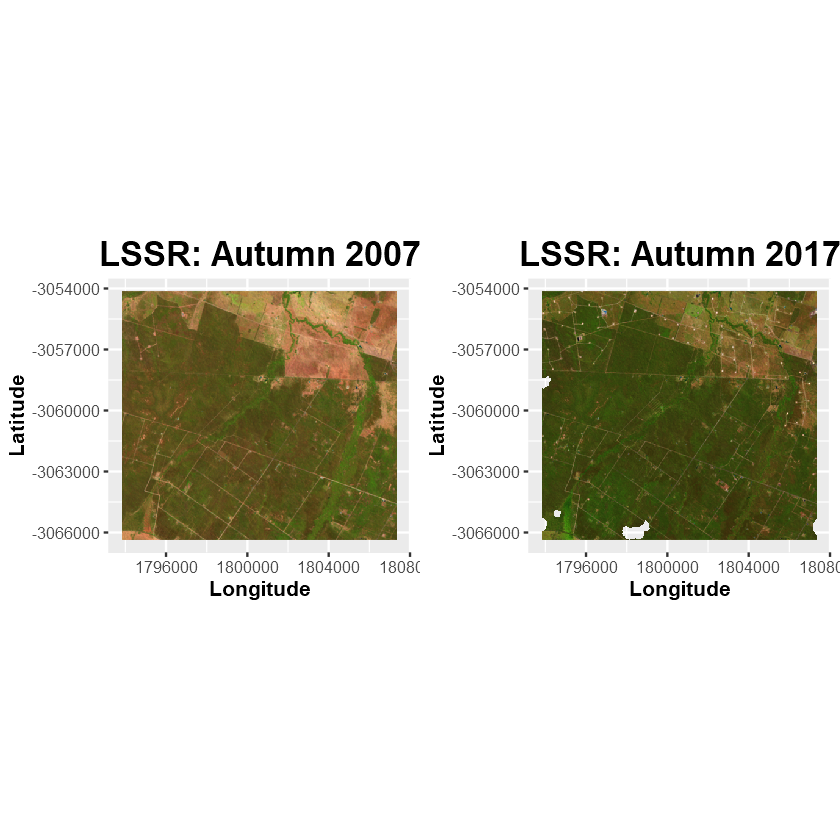

In [4]:
getwd()
# Data Path and Data (Landsat Surface Refectance, LSSR) Files Names
data.path = "http://qld.auscover.org.au/public/data/landsat/surface_reflectance/aus"
data.2007.fn = "lztmre_aus_m200703200705_dbia2.vrt"
data.2017.fn = "l8olre_aus_m201703201705_dbia2.vrt"


# Create RasterBricks with LSSR Data for the required Extent and Period
# =====================================================================

# Autumn 2007
# -----------

# Create RasterBrick with data
wofTara.2007.LSSR.rB = get.B3B4B5.rB.f( data.fpn=paste(data.path, data.2007.fn, sep="/"), dl.fn="LSSR_2007.vrt", rB.extent=WofTara.extent, rB.crs=CRS("+init=epsg:4326") )

wofTara.2007.LSSR.rB

# Create Plot of RasterBrick
wofTara.2007.LSSR.p = ggRGB(wofTara.2007.LSSR.rB, r=3, g=2, b=1) + 
labs(title= "LSSR: Autumn 2007", x="Longitude", y="Latitude") +
theme(plot.title = element_text(hjust = 0.5, size=20, face="bold"), 
      axis.title = element_text(size=12, face="bold"), axis.text=element_text(size=9) )

# Autumn 2017
# -----------

# Create RasterBrick with data
wofTara.2017.LSSR.rB = get.B3B4B5.rB.f( data.fpn=paste(data.path, data.2017.fn, sep="/"), dl.fn="LSSR_2017.vrt", 
                                        rB.extent=WofTara.extent, rB.crs=CRS("+init=epsg:4326") )

wofTara.2007.LSSR.rB

# Create Plot of RasterBrick
wofTara.2017.LSSR.p = ggRGB(wofTara.2017.LSSR.rB, r=3, g=2, b=1) + 
labs(title= "LSSR: Autumn 2017", x="Longitude", y="Latitude") +
theme(plot.title = element_text(hjust = 0.5, size=20, face="bold"), 
      axis.title = element_text(size=12, face="bold"), axis.text=element_text(size=9) )

	  
# Display both RasterBrick Plots in one plot
# ==========================================
grid.arrange(wofTara.2007.LSSR.p, wofTara.2017.LSSR.p, nrow=1)


### Compute NDVI from the extracted Subsets

In R raster calculations can be performed using:

* _\'Raster Algebra\' (also known s \'Raster Maths\'):_ Directly combining raster objects in a formula with the required calculations. We can use this formula directly, or place it in a function and call this function. Typically used for small rasters and simple calculations (not recommended otherwise).
* _\'Higher Level Functions\':_ First we place the formula with the required raster calculations in a function and then we use a Higher Level Function to invoke this function on relevant raster objects. This is more efficient (faster) option, which should be used for larger rasters and/or complex formulas. The Higher Level Function used depends on the number of raster object involved in the calculations:

  * _For a Single Raster Object:_ `calc` and `overlay` are most commonly used.
  * _For Multiple Raster Objects:_ `overlay` is typically used.
  
See **TERN's DSDP Tutorial 'Using Raster Data in R'** for details.

To compute NDVI values we first create a formula with the required maths (for details on the NDVI see text at the beginning of this section (NORMALIZED DIFFERENCE VEGETATION INDEX (NDVI) CHANGE ANALYSIS). We actually create two formulas, the first one passing the RasterBrick to be used with `calc` and the second one passing individual layers to be used with `overlay`. Then we calculate this index in different ways: 

  (1) using raster algebra (i.e. without calling any function) 
  (2) calling the a function we wrote to compute NDVI
  (3) using Higher level Functions that call the functions we wrote to calculate the NDVI: (3a) first using `calc` and (3b) then using `overlay`. 

Sometimes `calc` and `overlay` don't work; we show a trick (generating an empty raster with the right features and initialising it before assigning the values we need for our work to it) to help it work for us. The we compare the results of these 4 approaches to prove that the all produce the same results.

NOTE that in these datasets the value 32767 is used as a no-data code, so we will replace this value by NA


In [5]:
#=========================================================================================
# Create functions to Calculate NDVI
#=========================================================================================

# Function 1: Passing the RasterBrick
# -----------------------------------

calc.NDVI.f1 = function(rb) {

	NDVI.rL = (rb[["Band4.NIR"]] - rb[["Band3.Red"]]) / (rb[["Band4.NIR"]] + rb[["Band3.Red"]])
	return(NDVI.rL)

} # calc.NDVI.f1 = function(rb) {


# Function 2: Passing both RaterLayers
# -----------------------------------

calc.NDVI.f2 = function(rl.B4, rl.B3) {

	NDVI.rL = (rl.B4 - rl.B3) / (rl.B4 + rl.B3)
	return(NDVI.rL)

} # calc.NDVI.f2 = function(rl.B4, rl.B3) {


#=========================================================================================
# (1) Calculate NDVIs using Raster Algebra (= Raster Maths)
#=========================================================================================

# NDVI for 2007
# -------------
wofTara.2007.NDVI.rL.1 = (wofTara.2007.LSSR.rB[["Band4.NIR"]] - wofTara.2007.LSSR.rB[["Band3.Red"]]) / 
                         (wofTara.2007.LSSR.rB[["Band4.NIR"]] + wofTara.2007.LSSR.rB[["Band3.Red"]])
wofTara.2007.NDVI.rL.1

# NDVI for 2017
# -------------		   
wofTara.2017.NDVI.rL.1 = (wofTara.2017.LSSR.rB[["Band4.NIR"]] - wofTara.2017.LSSR.rB[["Band3.Red"]]) / 
                         (wofTara.2017.LSSR.rB[["Band4.NIR"]] + wofTara.2017.LSSR.rB[["Band3.Red"]])
wofTara.2017.NDVI.rL.1


(wofTara.2017.LSSR.rB[["Band3.Red"]] - wofTara.2017.LSSR.rB[["Band4.NIR"]]) / 
                         (wofTara.2017.LSSR.rB[["Band4.NIR"]] + wofTara.2017.LSSR.rB[["Band3.Red"]])


#=========================================================================================
# (2) Directly calling one of the functions we created above to compute NDVI
#=========================================================================================
# NDVI for 2007
# -------------
wofTara.2007.NDVI.rL.2 = calc.NDVI.f1(rb = wofTara.2007.LSSR.rB)
wofTara.2007.NDVI.rL.2

# NDVI for 2017
# -------------		   
wofTara.2017.NDVI.rL.2 = calc.NDVI.f1(rb = wofTara.2017.LSSR.rB)
wofTara.2017.NDVI.rL.2			   


#=========================================================================================
# (3) Using Higher Level Functions
#=========================================================================================

#-----------------------------------------------------------------------------------------
# (3a) Using  'calc' & our 1st function to calculate NDVI
#-----------------------------------------------------------------------------------------
# Section before 'TRICK' commented out because it doesnt' work. Can give it a try
# by removing the comments.

## NDVI for 2007
## .............
#wofTara.2007.NDVI.rL.3a1 = calc(rb=wofTara.2007.LSSR.rB, fun=calc.NDVI.f1)
#wofTara.2007.NDVI.rL.3a1

# NDVI for 2017
# .............
#wofTara.2017.NDVI.rL.3a1 = calc(rb=wofTara.2017.LSSR.rB, fun=calc.NDVI.f1)
#wofTara.2017.NDVI.rL.3a1


# TRICK: Create & Initialise the Raster container and then copy the RasterLayers on it
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# All years have the same dimensions
rL <- raster( ncol=ncol(wofTara.2007.LSSR.rB[["Band4.NIR"]]), 
              nrow=nrow(wofTara.2007.LSSR.rB[["Band4.NIR"]]) )
rL.B4.NIR <- init(rL, fun=runif)
rL.B3.Red <- init(rL, fun=runif)		

# NDVI for 2007
# .............
rL.B4.NIR = wofTara.2007.LSSR.rB[["Band4.NIR"]]
rL.B3.Red = wofTara.2007.LSSR.rB[["Band3.Red"]]
rB = brick(rL.B4.NIR, rL.B3.Red)
names(rB) = c("Band4.NIR", "Band3.Red")
wofTara.2007.NDVI.rL.3a2 = calc(rB, fun=calc.NDVI.f1)
wofTara.2007.NDVI.rL.3a2

# NDVI for 2017
# .............
rL.B4.NIR = wofTara.2017.LSSR.rB[["Band4.NIR"]]
rL.B3.Red = wofTara.2017.LSSR.rB[["Band3.Red"]]
rB = brick(rL.B4.NIR, rL.B3.Red)
names(rB) = c("Band4.NIR", "Band3.Red")
wofTara.2017.NDVI.rL.3a2 = calc(rB, fun=calc.NDVI.f1)
wofTara.2017.NDVI.rL.3a2


#-----------------------------------------------------------------------------------------
# (3b) Using  'overlay' & our 2nd function to calculate NDVI
#-----------------------------------------------------------------------------------------
# Section before 'TRICK' commented out because it doesnt' work. Can give it a try
# by removing the comments.

## NDVI for 2007
## .............
#wofTara.2007.NDVI.rL.3b1 = overlay( rl.B4=wofTara.2007.LSSR.rB[["Band4.NIR"]],
#                                    rl.B3=wofTara.2007.LSSR.rB[["Band3.Red"]],
#                                    fun=calc.NDVI.f2)
#wofTara.2007.NDVI.rL.3b1

## NDVI for 2017
## .............
#wofTara.2017.NDVI.rL.3b1 = overlay( rl.B4=wofTara.2017.LSSR.rB[["Band4.NIR"]],
#                                    rl.B3=wofTara.2017.LSSR.rB[["Band3.Red"]],
#                                    fun=calc.NDVI.f2)
#wofTara.2017.NDVI.rL.3b1


# TRICK: Create & Initialise the Raster container and then copy the RasterLayers on it
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# All years have the same dimensions
rL <- raster( ncol=ncol(wofTara.2007.LSSR.rB[["Band4.NIR"]]), 
              nrow=nrow(wofTara.2007.LSSR.rB[["Band4.NIR"]]) )
rL.B4.NIR <- init(rL, fun=runif)
rL.B3.Red <- init(rL, fun=runif)			 

# NDVI for 2007
# .............
rL.B4.NIR = wofTara.2007.LSSR.rB[["Band4.NIR"]]
rL.B3.Red = wofTara.2007.LSSR.rB[["Band3.Red"]]
wofTara.2007.NDVI.rL.3b2 = overlay(rL.B4.NIR, rL.B3.Red, fun=calc.NDVI.f2)
wofTara.2007.NDVI.rL.3b2

# NDVI for 2017
# .............
rL.B4.NIR = wofTara.2017.LSSR.rB[["Band4.NIR"]]
rL.B3.Red = wofTara.2017.LSSR.rB[["Band3.Red"]]
wofTara.2017.NDVI.rL.3b2 = overlay(rL.B4.NIR, rL.B3.Red, fun=calc.NDVI.f2)
wofTara.2017.NDVI.rL.3b2


#=========================================================================================
# Compare Results (those we can compare)
#=========================================================================================

# NDVI for 2007
# .............
all.equal(wofTara.2007.NDVI.rL.1, wofTara.2007.NDVI.rL.2)
all.equal(wofTara.2007.NDVI.rL.1, wofTara.2007.NDVI.rL.3a2)
all.equal(wofTara.2007.NDVI.rL.1, wofTara.2007.NDVI.rL.3b2)

# NDVI for 2017
# .............
all.equal(wofTara.2017.NDVI.rL.1, wofTara.2017.NDVI.rL.2)
all.equal(wofTara.2017.NDVI.rL.1, wofTara.2017.NDVI.rL.3a2)
all.equal(wofTara.2017.NDVI.rL.1, wofTara.2017.NDVI.rL.3b2)


# Remove unneeded Raster Objects
# ------------------------------
ls(pattern="rL.2|rL.3")
rm(list=ls(pattern="rL.2|rL.3"))

class       : RasterLayer 
dimensions  : 408, 451, 184008  (nrow, ncol, ncell)
resolution  : 30, 30  (x, y)
extent      : 1793835, 1807365, -3066365, -3054125  (xmin, xmax, ymin, ymax)
coord. ref. : +proj=aea +lat_1=-18 +lat_2=-36 +lat_0=0 +lon_0=132 +x_0=0 +y_0=0 +ellps=GRS80 +units=m +no_defs 
data source : in memory
names       : layer 
values      : -0.08312343, 0.7602862  (min, max)


class       : RasterLayer 
dimensions  : 408, 451, 184008  (nrow, ncol, ncell)
resolution  : 30, 30  (x, y)
extent      : 1793835, 1807365, -3066365, -3054125  (xmin, xmax, ymin, ymax)
coord. ref. : +proj=aea +lat_1=-18 +lat_2=-36 +lat_0=0 +lon_0=132 +x_0=0 +y_0=0 +ellps=GRS80 +units=m +no_defs 
data source : in memory
names       : layer 
values      : -0.6510903, 0.8544872  (min, max)


class       : RasterLayer 
dimensions  : 408, 451, 184008  (nrow, ncol, ncell)
resolution  : 30, 30  (x, y)
extent      : 1793835, 1807365, -3066365, -3054125  (xmin, xmax, ymin, ymax)
coord. ref. : +proj=aea +lat_1=-18 +lat_2=-36 +lat_0=0 +lon_0=132 +x_0=0 +y_0=0 +ellps=GRS80 +units=m +no_defs 
data source : in memory
names       : layer 
values      : -0.8544872, 0.6510903  (min, max)


class       : RasterLayer 
dimensions  : 408, 451, 184008  (nrow, ncol, ncell)
resolution  : 30, 30  (x, y)
extent      : 1793835, 1807365, -3066365, -3054125  (xmin, xmax, ymin, ymax)
coord. ref. : +proj=aea +lat_1=-18 +lat_2=-36 +lat_0=0 +lon_0=132 +x_0=0 +y_0=0 +ellps=GRS80 +units=m +no_defs 
data source : in memory
names       : layer 
values      : -0.08312343, 0.7602862  (min, max)


class       : RasterLayer 
dimensions  : 408, 451, 184008  (nrow, ncol, ncell)
resolution  : 30, 30  (x, y)
extent      : 1793835, 1807365, -3066365, -3054125  (xmin, xmax, ymin, ymax)
coord. ref. : +proj=aea +lat_1=-18 +lat_2=-36 +lat_0=0 +lon_0=132 +x_0=0 +y_0=0 +ellps=GRS80 +units=m +no_defs 
data source : in memory
names       : layer 
values      : -0.6510903, 0.8544872  (min, max)


class       : RasterLayer 
dimensions  : 408, 451, 184008  (nrow, ncol, ncell)
resolution  : 30, 30  (x, y)
extent      : 1793835, 1807365, -3066365, -3054125  (xmin, xmax, ymin, ymax)
coord. ref. : +proj=aea +lat_1=-18 +lat_2=-36 +lat_0=0 +lon_0=132 +x_0=0 +y_0=0 +ellps=GRS80 +units=m +no_defs 
data source : in memory
names       : layer 
values      : -0.08312343, 0.7602862  (min, max)


class       : RasterLayer 
dimensions  : 408, 451, 184008  (nrow, ncol, ncell)
resolution  : 30, 30  (x, y)
extent      : 1793835, 1807365, -3066365, -3054125  (xmin, xmax, ymin, ymax)
coord. ref. : +proj=aea +lat_1=-18 +lat_2=-36 +lat_0=0 +lon_0=132 +x_0=0 +y_0=0 +ellps=GRS80 +units=m +no_defs 
data source : in memory
names       : layer 
values      : -0.6510903, 0.8544872  (min, max)


class       : RasterLayer 
dimensions  : 408, 451, 184008  (nrow, ncol, ncell)
resolution  : 30, 30  (x, y)
extent      : 1793835, 1807365, -3066365, -3054125  (xmin, xmax, ymin, ymax)
coord. ref. : +proj=aea +lat_1=-18 +lat_2=-36 +lat_0=0 +lon_0=132 +x_0=0 +y_0=0 +ellps=GRS80 +units=m +no_defs 
data source : in memory
names       : layer 
values      : -0.08312343, 0.7602862  (min, max)


class       : RasterLayer 
dimensions  : 408, 451, 184008  (nrow, ncol, ncell)
resolution  : 30, 30  (x, y)
extent      : 1793835, 1807365, -3066365, -3054125  (xmin, xmax, ymin, ymax)
coord. ref. : +proj=aea +lat_1=-18 +lat_2=-36 +lat_0=0 +lon_0=132 +x_0=0 +y_0=0 +ellps=GRS80 +units=m +no_defs 
data source : in memory
names       : layer 
values      : -0.6510903, 0.8544872  (min, max)


[1] TRUE

[1] TRUE

[1] TRUE

[1] TRUE

[1] TRUE

[1] TRUE

[1] "wofTara.2007.NDVI.rL.2"   "wofTara.2007.NDVI.rL.3a2"
[3] "wofTara.2007.NDVI.rL.3b2" "wofTara.2017.NDVI.rL.2"  
[5] "wofTara.2017.NDVI.rL.3a2" "wofTara.2017.NDVI.rL.3b2"


 We now plot the NDVI rasters using the `levelplot` function from the `rasterVis` package, which produces nice plots with more information than the standard `plot` function in the `raster` package`. We plot low NDVI values in red, intermediate values in yellow, and high values in green (the higher NDVI the darker the green).  

To plot the NDVI's of both year we first create a RasterBrick with both RasterLayers. We could plot both RasterLayers side to side but by default this would produce smaller plots as the plots would include density plots on their margins, which are not strictly comparable. They would also include two scales; plotting a RasterBrick a single scale is shown.


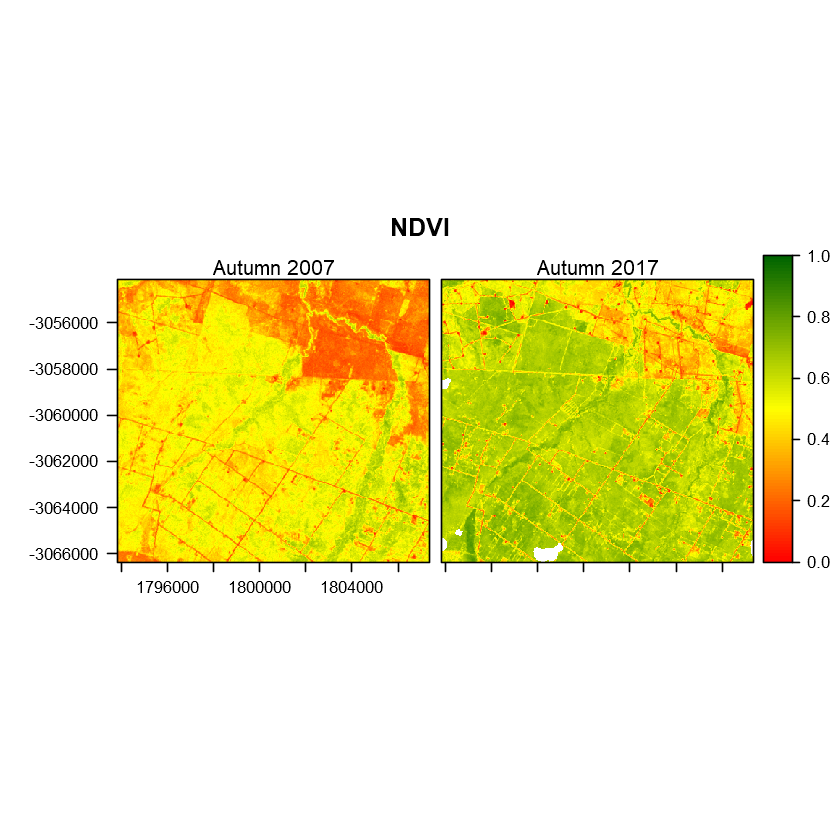

In [6]:
#=========================================================================================
# Plot NDVI rasters
#=========================================================================================

# Create the color palette
# ------------------------ 
# Red: low NDVIs, Yellow: middle NDVIs; Green: high NDVIs (Darker Greens indicate Higher NDVIs)
NDVI.breaks = seq(0,1,by=0.01)
NDVI.cols = colorRampPalette(c("red", "yellow", "darkgreen"))(length(NDVI.breaks)-1)

# Create side by side plots
# -------------------------
wofTara.NDVIs.rB = brick(wofTara.2007.NDVI.rL.1, wofTara.2017.NDVI.rL.1)
names(wofTara.NDVIs.rB) = c("NDVI.Autumn 2007", "NDVI.Autumn 2017")
levelplot(wofTara.NDVIs.rB, at=NDVI.breaks, col.regions=NDVI.cols, main="NDVI", names.attr=c("Autumn 2007","Autumn 2017"))


### NDVI Change Analysis

Now we explore the change in NDVI in the 10 year period (2007 to 2017). First, we compute the change in NDVI and then we visualise it.

#### NDVI Change Calculations

To explore the change in NDVI we substract the NDVI values of 2007 from 2017. Therefore, positive values indicate an increase in NDVI, 0 no change, and negative values a decrease in NDVI.

Differences in NDVI can be due to many factors. Typically, the largest difference is due to climatic effects. Here the overall larger NDVIs in 2017 than in 2007 are due to a much wetter start of the year in 2017 than in in 2007. However, there are also specific areas of change. There are more watering points (indicated by very low NDVI values) and there is more coal seam gas infrastructure. 

To make changes in NDVI slightly easier to interpret we normalise NDVI values (i.e. (NDVI - mean(NDVI)) / std(NDVI) ), so that 0 represent the mean NDVI and changes are in standard deviations of NDVI. To compute the summary statics values of a raster object (e.g. mean and standard deviation in our case) we need to use the `cellStats` function in the `raster` package. See *TERN's DSDP Tutorial 'Using Raster Data in R'* for details.

As when we calculated NDVI, NDVI changes (both in absolute NDIV values and in stdev. units) can be computed using:

* 'Raster Algebra' (= 'Raster Maths'): either directly using a formula, or placing this formula in a function and calling the function.
* 'Higher Level Functions', such as `calc` and `overlay`.

For normalising the NDVI values in a raster we can use the function `normImage` in the package `RStoolbox`. We could incorporate this function both in 'Raster Algebra' formula/function and in the function called by the 'Higher Level Function'. Here we will use 'Raster Algebra' both specifying the complete formula and taking advantage of the function `normImage`.


In [7]:
# Difference in 'raw' NDVI values
# ===============================
wofTara.NDVI.Diff.2017to2007.rL = wofTara.2017.NDVI.rL.1 - wofTara.2007.NDVI.rL.1
wofTara.NDVI.Diff.2017to2007.rL


# Difference in normalise NDVI values
# ===================================

# Method 1: Specifiying the whole formula
# ---------------------------------------
wofTara.NDVI.NormDiff.2017to2007.rL.m1 = 
	((wofTara.2017.NDVI.rL.1 - cellStats(wofTara.2017.NDVI.rL.1,mean)) / cellStats(wofTara.2017.NDVI.rL.1,sd)) - 
	((wofTara.2007.NDVI.rL.1 - cellStats(wofTara.2007.NDVI.rL.1,mean)) / cellStats(wofTara.2007.NDVI.rL.1,sd))	
wofTara.NDVI.NormDiff.2017to2007.rL.m1

# Method 2: Using the 'normImage' function in the 'RStoolbox' package
# -------------------------------------------------------------------
wofTara.NDVI.NormDiff.2017to2007.rL.m2 = normImage(wofTara.2017.NDVI.rL.1) - 
										 normImage(wofTara.2007.NDVI.rL.1)
wofTara.NDVI.NormDiff.2017to2007.rL.m2

# Compare results by both Normalisation Methods
# ---------------------------------------------
all.equal(wofTara.NDVI.NormDiff.2017to2007.rL.m1, wofTara.NDVI.NormDiff.2017to2007.rL.m2)

class       : RasterLayer 
dimensions  : 408, 451, 184008  (nrow, ncol, ncell)
resolution  : 30, 30  (x, y)
extent      : 1793835, 1807365, -3066365, -3054125  (xmin, xmax, ymin, ymax)
coord. ref. : +proj=aea +lat_1=-18 +lat_2=-36 +lat_0=0 +lon_0=132 +x_0=0 +y_0=0 +ellps=GRS80 +units=m +no_defs 
data source : in memory
names       : layer 
values      : -1.229459, 0.606049  (min, max)


class       : RasterLayer 
dimensions  : 408, 451, 184008  (nrow, ncol, ncell)
resolution  : 30, 30  (x, y)
extent      : 1793835, 1807365, -3066365, -3054125  (xmin, xmax, ymin, ymax)
coord. ref. : +proj=aea +lat_1=-18 +lat_2=-36 +lat_0=0 +lon_0=132 +x_0=0 +y_0=0 +ellps=GRS80 +units=m +no_defs 
data source : in memory
names       : layer 
values      : -10.9933, 3.723755  (min, max)


class       : RasterLayer 
dimensions  : 408, 451, 184008  (nrow, ncol, ncell)
resolution  : 30, 30  (x, y)
extent      : 1793835, 1807365, -3066365, -3054125  (xmin, xmax, ymin, ymax)
coord. ref. : +proj=aea +lat_1=-18 +lat_2=-36 +lat_0=0 +lon_0=132 +x_0=0 +y_0=0 +ellps=GRS80 +units=m +no_defs 
data source : in memory
names       : layer 
values      : -10.9933, 3.723755  (min, max)


[1] TRUE


#### NDVI Change Visualizations

 To visualise the changes in 'raw' and normalised NDVI we will examine:

  * The NDVI values of individual years using:
    * _Boxplots:_ Using the function `bwplot` from the package `rasterVis`. This function creates violin plots, a boxplot with a kernel density plot.
    * _Matrix of scatterplots with a fitted loess_ to investigate the relationship between both years.
  * The NDVI values of individual years and their change using _Density plots:_ We will build the density plots in two ways: 
    * Using the function `densityplot` from the package `rasterVis`: Simple easy plots.
    * Using the function `ggplot` from the package `ggplot2`:  This looks prettier and is more flexible, but requires more work.
  * The NDVI change between years by _Plotting a RasterLayer_ of this change (in both scales: raw NDVIs and normalised NDVIs).

 We will start by creating a RasterBrick object to pass to many of the plotting functions (e.g. the functions in the package `rasterVis`). 


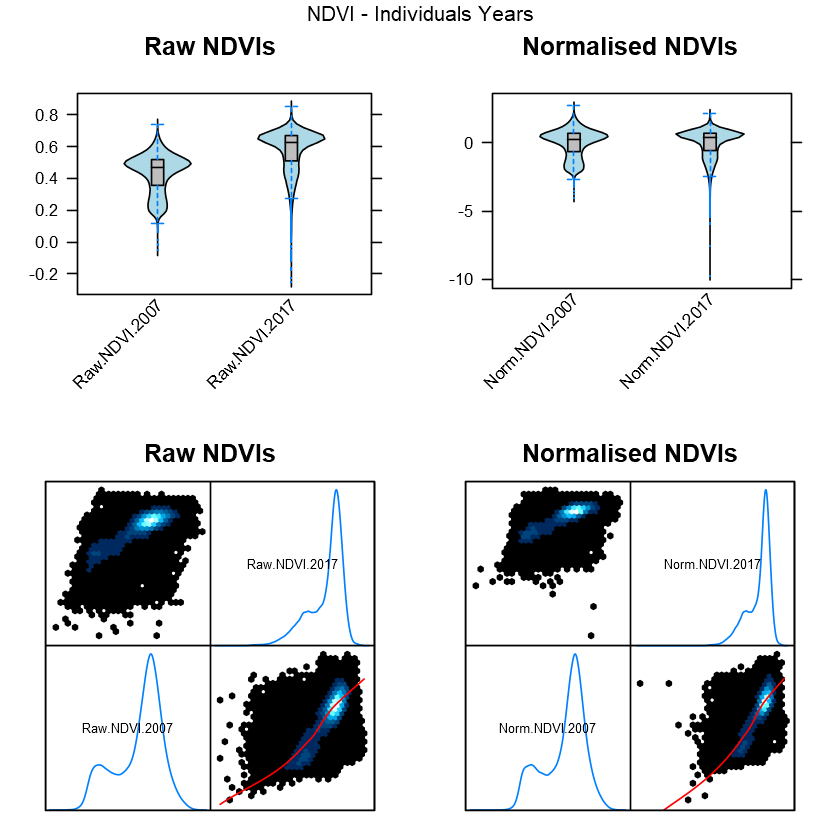

No id variables; using all as measure variables
No id variables; using all as measure variables
Warning message:
"Removed 1396 rows containing non-finite values (stat_density)."Warning message:
"Removed 1396 rows containing non-finite values (stat_density)."Warning message:
"Removed 1396 rows containing non-finite values (stat_density)."Warning message:
"Removed 1396 rows containing non-finite values (stat_density)."

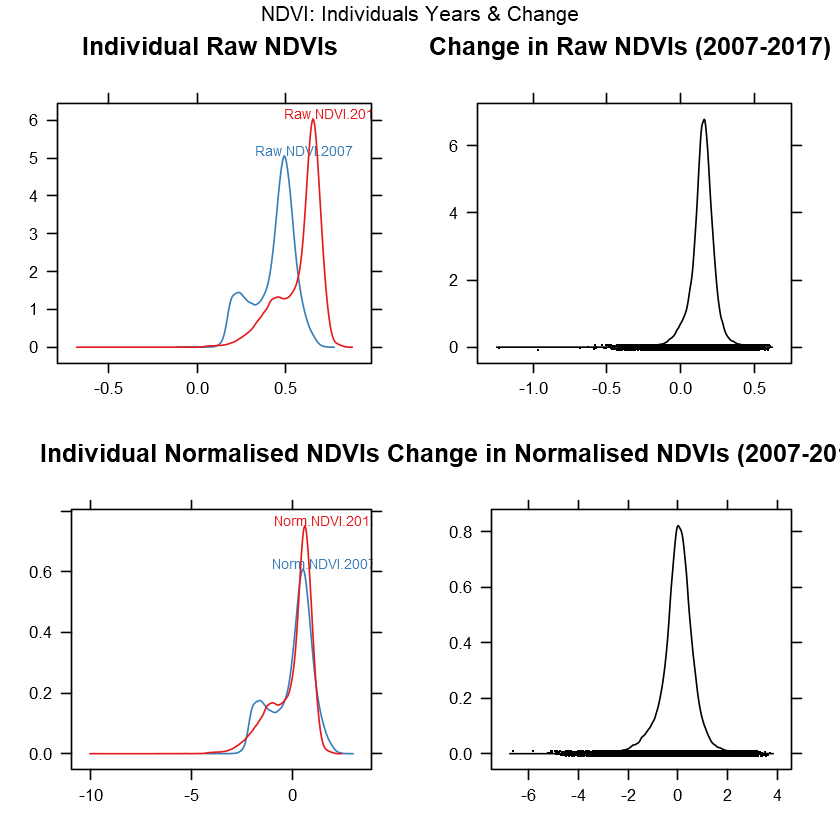

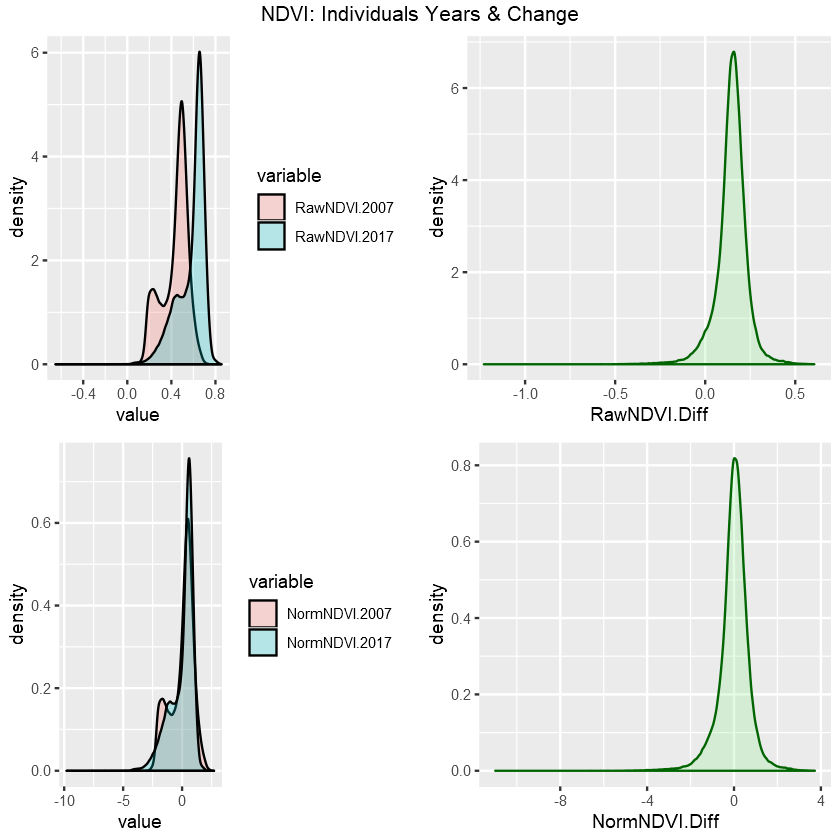

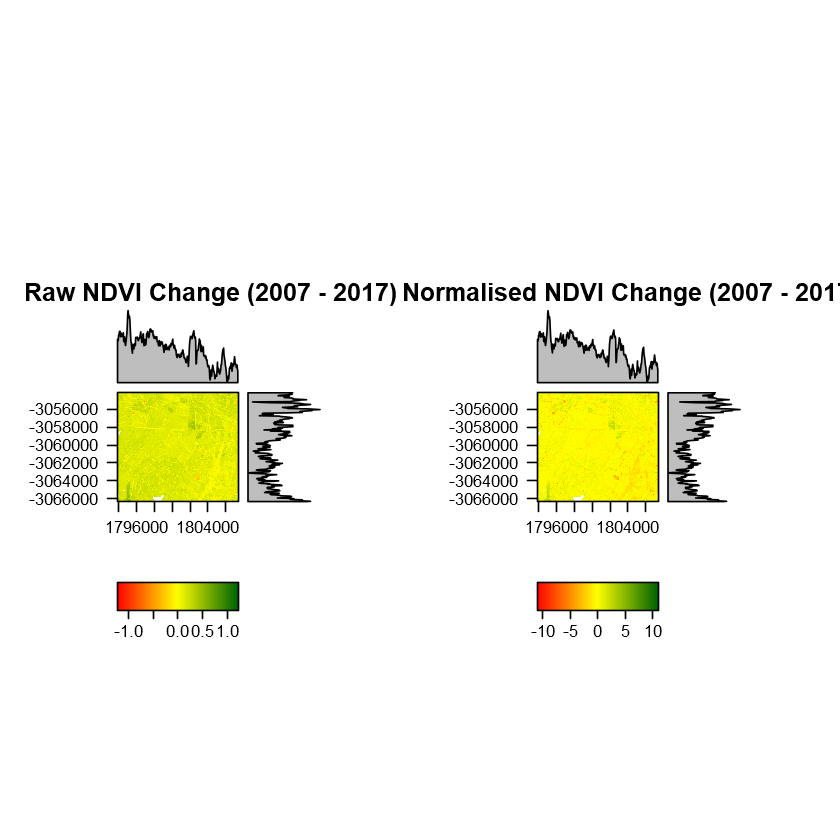

In [8]:

# =========================
# Create RasterBrick object
# =========================

# 'Raw' NDVIs: Already done above (see 'Plot NDVI rasters' section)
# ...........
wofTara.RawNDVIs.rB = brick(wofTara.2007.NDVI.rL.1, wofTara.2017.NDVI.rL.1) 
names(wofTara.RawNDVIs.rB) = c("Raw.NDVI.2007", "Raw.NDVI.2017")

# Normalised NDVIs
# ................
wofTara.2007.NormNDVI.rL.1 = normImage(wofTara.2007.NDVI.rL.1)
wofTara.2017.NormNDVI.rL.1 = normImage(wofTara.2017.NDVI.rL.1)
wofTara.NormNDVIs.rB = brick(wofTara.2007.NormNDVI.rL.1, wofTara.2017.NormNDVI.rL.1)
names(wofTara.NormNDVIs.rB) = c("Norm.NDVI.2007", "Norm.NDVI.2017")


# ========
# Boxplots
# ========

# Change in 'Raw' NDVI
# ....................
RawNDVI.IndvYrs.bwplot = bwplot(wofTara.RawNDVIs.rB, main="Raw NDVIs")

# Change in Normalised NDVI
# .........................
NormNDVI.IndvYrs.bwplot = bwplot(wofTara.NormNDVIs.rB, main="Normalised NDVIs")


# ========================
# Scatter plots with loess
# ========================

# Change in 'Raw' NDVI
# ....................
RawNDVI.IndvYrs.splot = splom(wofTara.RawNDVIs.rB, main="Raw NDVIs", plot.loess=TRUE, xlab='')

# Change in Normalised NDVI
# .........................
NormNDVI.IndvYrs.splot = splom(wofTara.NormNDVIs.rB, main="Normalised NDVIs", plot.loess=TRUE, xlab='')


# -------------------------------------
# Combine the 4 Plots in a single Graph
# -------------------------------------
grid.arrange( RawNDVI.IndvYrs.bwplot, NormNDVI.IndvYrs.bwplot, 
			  RawNDVI.IndvYrs.splot, NormNDVI.IndvYrs.splot,
              nrow=2, top="NDVI - Individuals Years" )

			  
	   
# =============	   
# Density Plots
# =============

# ----------------------------------------------------------
# Method 1: Using 'densityplot' from the package 'rasterVis`
# ----------------------------------------------------------

# Change in 'Raw' NDVI
# ....................
RawNDVI.IndvYrs.dp = densityplot(wofTara.RawNDVIs.rB, main="Individual Raw NDVIs")
RawNDVI.Diff.dp = densityplot(wofTara.NDVI.Diff.2017to2007.rL, main="Change in Raw NDVIs (2007-2017)")

# Change in Normalised NDVI
# .........................
NormNDVI.IndvYrs.dp = densityplot(wofTara.NormNDVIs.rB, main="Individual Normalised NDVIs")
NormNDVI.Diff.dp = densityplot(wofTara.NDVI.NormDiff.2017to2007.rL.m2, main="Change in Normalised NDVIs (2007-2017)")

# Combine 4 Plots in a Graph
# ..........................
grid.arrange( RawNDVI.IndvYrs.dp, RawNDVI.Diff.dp, NormNDVI.IndvYrs.dp, NormNDVI.Diff.dp,
              nrow=2, top="NDVI: Individuals Years & Change" )


# ---------------------------------------------------
# Method 2: Using 'ggplot' from the package 'ggplot2`
# ---------------------------------------------------

# Create a DataFrame with the required values 
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Create a DataFrame with the required values to pass to function 'ggplot' in the package 'ggplot2' 
# Required values: NDVIs for 2007, 2017, and their difference in both scales: raw and normalised.
RawNDVI.2007 = values(wofTara.2007.NDVI.rL.1)
RawNDVI.2017 = values(wofTara.2017.NDVI.rL.1)
RawNDVI.Diff = values(wofTara.NDVI.Diff.2017to2007.rL)
NormNDVI.2007 = values(wofTara.2007.NormNDVI.rL.1)
NormNDVI.2017 = values(wofTara.2017.NormNDVI.rL.1)
NormNDVI.Diff = values(wofTara.NDVI.NormDiff.2017to2007.rL.m2)
NDVIs.df = data.frame( RawNDVI.2007, RawNDVI.2017, RawNDVI.Diff, 
					   NormNDVI.2007, NormNDVI.2017, NormNDVI.Diff )
#summary(NDVIs.df)
							   

# Change in 'Raw' NDVI
# ~~~~~~~~~~~~~~~~~~~~

# Density plot of Raw NDVI values for Individual Years: 
# .....................................................
# Subset Dataset and convert wide format to long format
RawNDVI.IndvYrs.dflf = melt(NDVIs.df[c("RawNDVI.2007","RawNDVI.2017")])
RawNDVI.IndvYrs.dp2 = ggplot(RawNDVI.IndvYrs.dflf, aes(x=value, fill=variable)) +
				      geom_density(alpha=0.25)
				   
# Density plot of the change in Raw NDVI values
# .............................................
RawNDVI.Diff.dp2 = ggplot(NDVIs.df, aes(x=RawNDVI.Diff)) + 
				   geom_density(alpha=0.25,color="darkgreen", fill="lightgreen")
				   

# Change in Normalised NDVI
# ~~~~~~~~~~~~~~~~~~~~~~~~~

# Density plot of Raw NDVI values for Individual Years: 
# .....................................................
# Subset Dataset and convert wide format to long format
NormNDVI.IndvYrs.dflf = melt(NDVIs.df[c("NormNDVI.2007","NormNDVI.2017")])
NormNDVI.IndvYrs.dp2 = ggplot(NormNDVI.IndvYrs.dflf, aes(x=value, fill=variable)) +
				       geom_density(alpha=0.25)
				   
# Density plot of the change in Raw NDVI values
# .............................................
NormNDVI.Diff.dp2 = ggplot(NDVIs.df, aes(x=NormNDVI.Diff)) + 
					geom_density(alpha=0.25,color="darkgreen", fill="lightgreen")

					
# Combine the 4 Plots in a single Graph
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
grid.arrange( RawNDVI.IndvYrs.dp2, RawNDVI.Diff.dp2, NormNDVI.IndvYrs.dp2,   NormNDVI.Diff.dp2,
              nrow=2, top="NDVI: Individuals Years & Change" )



# ============================================================
# Plot of the Raster Layer with the Normalised Change in NDVI
# ============================================================
# They have very differnt scales (raw NDVI and normalised NDVI values)

# -------------------
# Change in Raw NDVI 
# -------------------
#wofTara.NDVI.Diff.2017to2007.rL

# Create the color palette
# ........................
abs.max = max(abs(values(wofTara.NDVI.Diff.2017to2007.rL)), na.rm=TRUE)
# Red: low NDVIs, Yellow: middle NDVIs; Green: high NDVIs (Darker Greens indicate Higher NDVIs)
RawNDVI.Diff.breaks = seq(-abs.max,abs.max, by=0.01)
RawNDVI.Diff.cols = colorRampPalette(c("red", "yellow", "darkgreen"))(length(RawNDVI.Diff.breaks)-1)

# Create Raster Plots with Density Plots
# ......................................
wofTara.RawNDVIDiff.p = levelplot( wofTara.NDVI.Diff.2017to2007.rL, at=RawNDVI.Diff.breaks, 
								   col.regions=RawNDVI.Diff.cols, main="Raw NDVI Change (2007 - 2017)" )							   
								   
# -------------------------								   
# Change in Normalised NDVI
# -------------------------
#wofTara.NDVI.NormDiff.2017to2007.rL.m2

# Create the color palette
# ........................
abs.max = max(abs(values(wofTara.NDVI.NormDiff.2017to2007.rL.m2)), na.rm=TRUE)
# Red: low NDVIs, Yellow: middle NDVIs; Green: high NDVIs (Darker Greens indicate Higher NDVIs)
NormNDVI.Diff.breaks = seq(-abs.max,abs.max, by=0.01)
NormNDVI.Diff.cols = colorRampPalette(c("red", "yellow", "darkgreen"))(length(NormNDVI.Diff.breaks)-1)

							
# Create Raster Plots with Density Plots
# ......................................
wofTara.NormNDVIDiff.p = levelplot( wofTara.NDVI.NormDiff.2017to2007.rL.m2,   at=NormNDVI.Diff.breaks, col.regions=NormNDVI.Diff.cols, main="Normalised NDVI Change (2007 - 2017)")
							
# -----------------							
# Plot Raster Plots
# -----------------		
# `grid.arrange` provides multiple plots per page. They look good on screen, 
# but might be too small in the Workshop/Tutorial report. 
grid.arrange(wofTara.RawNDVIDiff.p, wofTara.NormNDVIDiff.p, nrow=1) # Too Small for Tut.
#wofTara.RawNDVIDiff.p   # Used if 'grid.arrange' leads to plots too small
#wofTara.NormNDVIDiff.p  # Used if 'grid.arrange' leads to plots too small



### Examine what's happening in the Area of Most Noticeable Greening up

 Aside from areas of where infrastructure has been put in and a small patch of clearing in the south-east corner, there is an area of noticeable greening up in the north-east.

 To examine what is happening here overtime we can plot a time series of the green fraction. The green fraction is one of the bands of the fractional cover product. This is another AusCover product hosted by TERN.

 Then we fit a trend line to the green data over the period of interest.

 The server hosts time series stacks of cover fractions in virtual files that make pulling out time series a breeze. However, individual bands could also be iterated without too many problems.


#### Greening Area: Define its Extent & Find out where it is

 To find our bearings we start by displaying the Greening Area. We do this in different ways:
 
 * Download and Display a map of the Greening Area from Stamen Maps.
 * Plot Satellite images of our study area (west of Tara) for years 2007 & 2017 with a (red) box indicating the Greening Area.
 * Plot the Normalised NDVI Change image with a (blue) box indicating the Greening Area.

 The plots for the Satellite (Surface Reflectance) images are `ggplot2` plots. The Normalised NDVI Change images is a `lattice` plot. The procedure to add a polygon box to ggplot2 & lattice plots differ. We plot both types of plots to show how to add a polygon in each case.


class       : Extent 
xmin        : 150.4436 
xmax        : 150.4458 
ymin        : -27.0062 
ymax        : -27.0037 

Map tiles by Stamen Design, under CC BY 3.0. Data by OpenStreetMap, under ODbL.


class       : SpatialPolygons 
features    : 1 
extent      : 150.4436, 150.4458, -27.0062, -27.0037  (xmin, xmax, ymin, ymax)
coord. ref. : NA 

class       : SpatialPolygons 
features    : 1 
extent      : 150.4436, 150.4458, -27.0062, -27.0037  (xmin, xmax, ymin, ymax)
coord. ref. : +init=epsg:4326 +proj=longlat +datum=WGS84 +no_defs +ellps=WGS84 +towgs84=0,0,0 

class       : SpatialPolygons 
features    : 1 
extent      : 1801860, 1802113, -3057837, -3057529  (xmin, xmax, ymin, ymax)
coord. ref. : +init=epsg:3577 +proj=aea +lat_1=-18 +lat_2=-36 +lat_0=0 +lon_0=132 +x_0=0 +y_0=0 +ellps=GRS80 +towgs84=0,0,0,0,0,0,0 +units=m +no_defs 

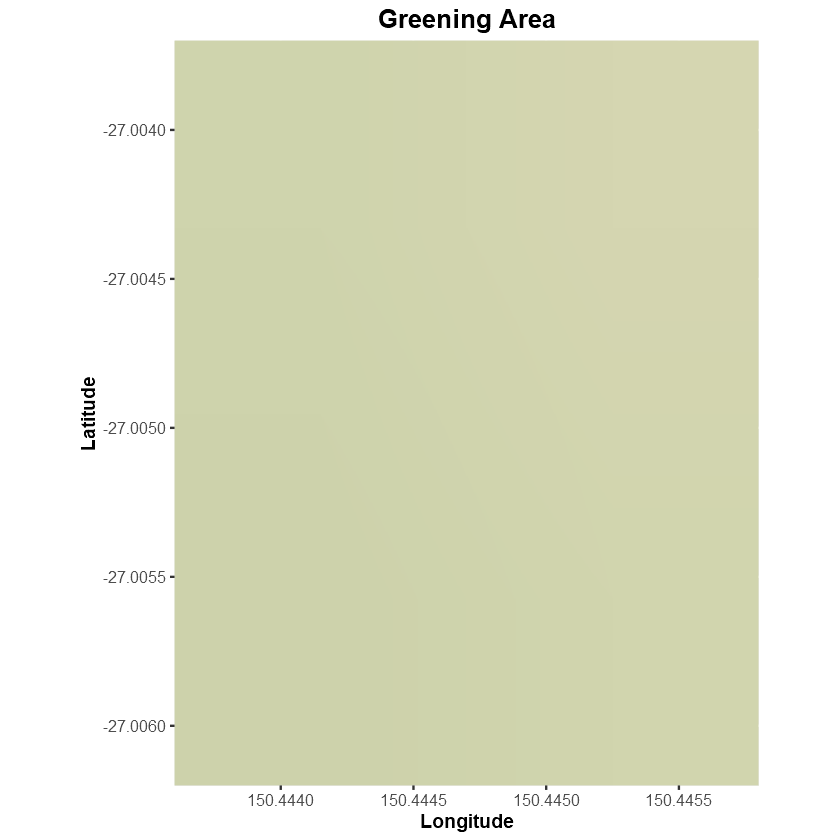

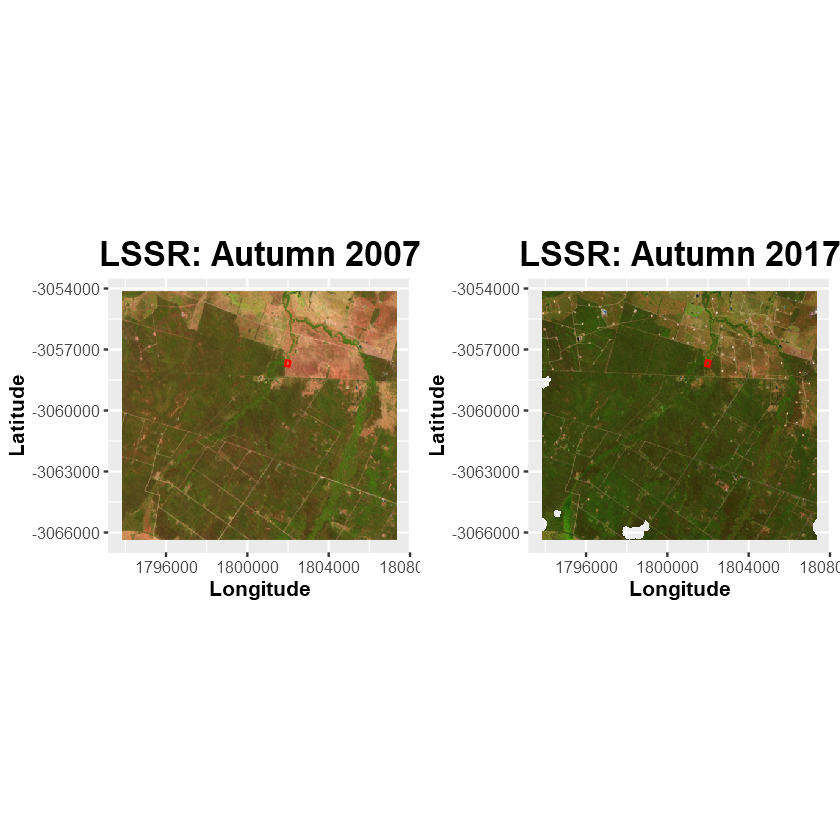

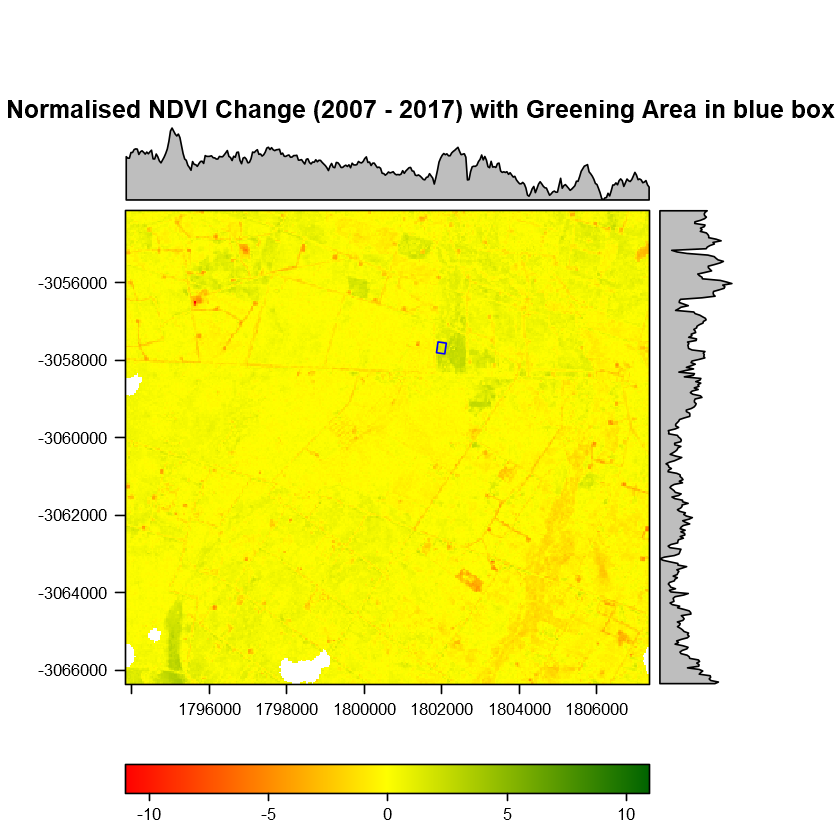

In [9]:

# Define the Extent of the Area to Explore
# ========================================
GreeningArea.extent = extent(150.4436, 150.4458, -27.0062, -27.0037)
GreeningArea.extent


# Plot Web Map for the Greening Area
# ==================================

# Get Map 
# -------
GreeningArea.StamenMap = get_stamenmap(GreeningArea.extent[c(1,3,2,4)], maptype="terrain")

# Create Plot of the Map
# ----------------------
# Stamen map of this area is not very detailed
GreeningArea.P1 = 
ggmap(GreeningArea.StamenMap) + labs(title= "Greening Area", x="Longitude", y="Latitude") +
theme(plot.title = element_text(hjust = 0.5, size=15, face="bold"), 
      axis.title = element_text(size=11, face="bold"), axis.text=element_text(size=9) )
GreeningArea.P1  


# Plot Greening Area over Satellite and NDVI Change Images
# ========================================================

# Create Polygon with the Greening Area Extent
# --------------------------------------------
GreeningArea.SP = as(GreeningArea.extent, "SpatialPolygons")
GreeningArea.SP  # Has no CRS
proj4string(GreeningArea.SP) = CRS("+init=epsg:4326") # Add CRS
GreeningArea.SP
GreeningArea.EPSG3577.SP = spTransform(GreeningArea.SP, crs("+init=epsg:3577"))
GreeningArea.EPSG3577.SP

# Plot Greening Area on Satellite Images
# --------------------------------------
# Plots 'wofTara.2007.LSSR.p' and 'wofTara.2017.LSSR.p' were created above.

# 2007 Image
# ~~~~~~~~~~
GreeningArea.2007.p = wofTara.2007.LSSR.p + 
					  geom_polygon(data=GreeningArea.EPSG3577.SP, aes(x=long, y=lat), 
					               color="red", alpha=0)

# 2007 Image
# ~~~~~~~~~~
GreeningArea.2017.p = wofTara.2017.LSSR.p + 
					  geom_polygon(data=GreeningArea.EPSG3577.SP, aes(x=long, y=lat), 
					               color="red", alpha=0)

# Plot Satellite Images from 2007 & 2017 with a Red Box for the Greening Area
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# `grid.arrange` provides multiple plots per page. They look good on screen, 
# but might be too small in the Workshop/Tutorial report. 
grid.arrange(GreeningArea.2007.p, GreeningArea.2017.p, nrow=1)
#GreeningArea.2007.p   # Used if 'grid.arrange' leads to plots too small
#GreeningArea.2017.p   # Used if 'grid.arrange' leads to plots too small

# Plot Greening Area on NDVI Change Image
# ---------------------------------------
# Parameters 'NormNDVI.Diff.breaks' & 'NormNDVI.Diff.cols' were created above 
# (when genrating plot 'wofTara.NormNDVIDiff.p'.

levelplot( wofTara.NDVI.NormDiff.2017to2007.rL.m2, at=NormNDVI.Diff.breaks, 
		   col.regions=NormNDVI.Diff.cols, 
		   main="Normalised NDVI Change (2007 - 2017) with Greening Area in blue box") +
layer(sp.polygons(GreeningArea.EPSG3577.SP, col="blue", fill=NA))



#### Download the dataset with the Green Cover Fraction 

 We start by downloading the `vrt` file containing the time series of green cover fraction. VRT is format (Virtual Format) driver for GDAL (Geospatial Data Abstraction Library) that allows building virtual GDAL datasets from other GDAL datasets. '.vrt' files contain 'VRT' descriptions of datasets typically saved in XML format. For further details see 'GDAL Virtual Format Tutorial' by GDAL organization [here](https://www.gdal.org/gdal_vrttut.html). 
 
To download the data file we need to provide the file location (i.e. URL) and name to the function `download.file`, as we did above for the function we used to download, read, subset, and combine the landsat surface reflectance data. If we have all these pieces of information (and providing a file name), downloading the data file is straightforward. However, the name of the data product files containing the time series of bare, green and non-green fractional cover change every ~3 months, as information for a new season is added to the previous data. The dataset file names include 12 digits that represent the period in which the data were collected; that is: starting year (4 digits), starting month (2 digits), ending year (4 digits), and ending month (2 digits). Therefore, the last 6 digits in the file name change every time new data is added. For example, in Peter Scarth's original python tutorial the file containing the time series for the green cover fraction was "lztmre_aus_s198712201705_dima2_green.vrt". Successive, versions of our R tutorial have used the data files "lztmre_aus_s198712201805_dima2_green.vrt", "lztmre_aus_s198712201808_dima2_green.vrt", and at the time of writing this version of the tutorial the latest green cover fraction time series file is "lztmre_aus_s198712201811_dima2_green.vrt".  Moreover, the previous files (i.e. containing data for shorter periods) are removed when the new files are added. Therefore, we need to find what is the name for the current data file containing the time series of green cover fractions. To do this we will use the function `readHTMLTable` in the package `XML` to extract the HTML tables containing all the file names in HTML document at the URL. The name of the file containing the time series of green cover fraction data always ends in "_green.vrt", so we use `grep` to find its position in the list of file names from the directory. Finally, we use this position to obtain the full name of the file, which we can then use in the function `download.file`.


In [10]:

# Data Path and Name
GCF.data.path = "http://qld.auscover.org.au/public/data/landsat/seasonal_fractional_cover/fractional_cover/aus"

# Data file name. However, these names won't last as they change when data for a new season is added (see above)
#GCF.data.fn = "lztmre_aus_s198712201705_dima2_green.vrt"
#GCF.data.fn = "lztmre_aus_s198712201805_dima2_green.vrt" # It has changed.
#GCF.data.fn = "lztmre_aus_s198712201808_dima2_green.vrt" # It's changed again!
#GCF.data.fn = "lztmre_aus_s198712201811_dima2_green.vrt" # It's changed again!!!

# Therefore we find the name of the current file from the HTML document at the URL
# using the function `readHTMLTable` from the library 'XML'
fn.in.path = as.character(readHTMLTable(GCF.data.path)[[1]]$Name)  # List of file names in the HTML document at the URL
GCF.data.fn.pos = grep("_green.vrt", fn.in.path)  # Position of the file containing the Green Cover Fraction TS.
GCF.data.fn = fn.in.path[GCF.data.fn.pos]  # (Complete) Name of the file containing the Green Cover Fraction TS.
GCF.data.fn

# Download the data file (if it doesn't work try method='wget' or functions in Library 'RCurl')
download.file(url=paste(GCF.data.path, GCF.data.fn, sep="/"), destfile='GreenCoverFraction.vrt', method='auto')
list.files(pattern = "\\.vrt$")  # '\\.': To escape previous characters, '$': End of string


[1] "lztmre_aus_s198712201811_dima2_green.vrt"

[1] "ASLM.vrt"               "GreenCoverFraction.vrt" "LSSR_2007.vrt"         
[4] "LSSR_2017.vrt"


#### Extract and Prepare (Crop and Re-code) the Bands of Interest (2007-2017)

 The green cover fraction vrt file currently contains 122 bands/layers. Four new bands are created and added each year. Bands 77-120 correspond to the period of interest, 2007-2017. Subsequent bands have been added for later seasons. You can check this (and the file structure) opening it in text editor such as Notepad.

 We create a new function to Load, Subset (i.e. Crop), Recode (the no-data values) and Combine the bands of interest. This function is partially similar to the function 'get.B3B4B5.rB.f' that we created above. Then we call this function to create a RasterBrick  containing the Green Cover Fraction bands of interest (bands 77-120 for the period 2007-2017) subsetted to the extent of the Greening Area we want to explore. 


In [11]:

#-----------------------------------------------------------------------------------------
# Create a function to Extract, Subset, Recode, and Combine the Bands into a Raster Brick
#-----------------------------------------------------------------------------------------

getprep.Bands.rB.f = function(dl.fn, bands.v, rB.extent, rB.crs){

	# Create cookie cutter: Extent projected to CRS=EPSG:3577
	# =======================================================
	#print(rB.extent)
	# Create a Polygon from Extent, Reproject the Poloygon and use its extension
	rB.extent.GeoCoord.SP = as(rB.extent, "SpatialPolygons")
	#print(rB.extent.GeoCoord.SP)  # Has no CRS
	proj4string(rB.extent.GeoCoord.SP) = CRS("+init=epsg:4326")
	#print(rB.extent.GeoCoord.SP)
	rB.extent.reprj.SP = spTransform(rB.extent.GeoCoord.SP, rB.crs)
	#print(rB.extent.reprj.SP)
	rB.extent.reprj = extent(rB.extent.reprj.SP)
	#print(rB.extent.reprj)

	# For each Band
	# =============
	for ( band.cnt in bands.v ) {
	
		#print(band.cnt)
	
		# Load the data to RasterLayer object
		# -----------------------------------
		GFC.rL = raster(dl.fn, band=band.cnt)
		#print(GFC.rL)
	
		# Subset (i.e. crop) raster layer to area of interest
		# ---------------------------------------------------
		GFC.Subset.rL = crop(GFC.rL, rB.extent.reprj)
		is.na(GFC.Subset.rL)
		#print(GFC.Subset.rL)
	
		# Replace values < 0 with NAs
		# ---------------------------
		# GFC.Subset.rL[GFC.Subset.rL < 0] = NA
	
		# Add Raster Layer to Raster Brick
		# --------------------------------
		if ( band.cnt == bands.v[1] ) {
			GFC.Subset.rB = brick(GFC.Subset.rL)
		} else {
			GFC.Subset.rB = addLayer(GFC.Subset.rB, GFC.Subset.rL)
		}  # } else {
			
	} # for ( band.cnt in bands.v ) {

	# Re-conver to RasterBrick object (if prefered)
	# =============================================
	# 'addLayer' (used in the for loop) returns a RasterStack object, so we need to re-convert 
	# object to a RasterBrick (if this is the prefered object class).
	GFC.Subset.rB = brick(GFC.Subset.rB)
	
	# Add Layer Names to Raster Brick
	# ===============================
	
	# Create a vector of Raster Layer names (including the Band, Year, and Quarter)
	band.part = paste("Band", bands.v, sep="")
	initial.year = 1988
	date.part = as.character(formatC(initial.year+bands.v/4-0.25,digits=2,format="f")) # '-0.25 'cos statrs in band1 not band0
	band.names = paste(band.part, date.part, sep="_")
	
	# Add the band names to the RasterBrick
	names(GFC.Subset.rB) = band.names
	#print(GFC.Subset.rB)

	# Return RasterBrick with the Required Bands Subset to the desired Extent
	# =======================================================================
	return(GFC.Subset.rB)	
 
} # getprep.Bands.rB.f = function(dl.fn, bands.v, rB.extent, rB.crs){


#-----------------------------------------------------------------------------------------
# Call the function to Create a Raster Brick with the processed Bands for 2007-2017
#-----------------------------------------------------------------------------------------

GreeningArea.rB =getprep.Bands.rB.f( dl.fn='GreenCoverFraction.vrt', bands.v=77:120, 
									 rB.extent=GreeningArea.extent, rB.crs=CRS("+init=epsg:3577") )
GreeningArea.rB


class       : RasterBrick 
dimensions  : 11, 9, 99, 44  (nrow, ncol, ncell, nlayers)
resolution  : 30, 30  (x, y)
extent      : 1801845, 1802115, -3057845, -3057515  (xmin, xmax, ymin, ymax)
coord. ref. : +proj=aea +lat_1=-18 +lat_2=-36 +lat_0=0 +lon_0=132 +x_0=0 +y_0=0 +ellps=GRS80 +units=m +no_defs 
data source : in memory
names       : Band77_2007.00, Band78_2007.25, Band79_2007.50, Band80_2007.75, Band81_2008.00, Band82_2008.25, Band83_2008.50, Band84_2008.75, Band85_2009.00, Band86_2009.25, Band87_2009.50, Band88_2009.75, Band89_2010.00, Band90_2010.25, Band91_2010.50, ... 
min values  :            100,            100,            101,            116,            121,            112,            110,            112,            114,            116,            120,            110,            118,            127,            112, ... 
max values  :            124,            128,            138,            149,            150,            142,            135,            127,            12


#### Compute the Mean Green Cover Fraction in the Greening Area for each raster layer

First we compute a vector with the mean Green Cover Fraction (GCF) in the Greening Area (GA) for each raster layers. The raster layer values are in scale 0-255, so we re-scale the mean value to scale of 0-100 to represent the Green Cover Fraction in Percentage. 

 Then we create a vector with the Times (Years and Quarters) for each of these raster layers. The function that we used to create the Raster Brick with all the relevant data computed the date for each layer and assigned it as part of the corresponding band (i.e. layer) name. Here, we take advantage of this and extract the Times from the bands names. We could also have calculated it in a similar fashion as it was done within the function.


In [12]:

# Compute the Mean GCF in the Greening Area for each of the Bands
# ================================================================
GCF.GA.Means = cellStats(GreeningArea.rB, mean)
GCF.GA.Means

# Create a vector with the Times for each of Bands 
# ================================================
#names(GCF.GA.Means)
GCF.GA.Times = as.numeric( sub(".*_","", names(GCF.GA.Means)) )
# OR:  as.numeric( sapply(strsplit(names(GCF.GA.Means),split="[_]"),"[",2) )
GCF.GA.Times


Band77_2007.00  Band78_2007.25  Band79_2007.50  Band80_2007.75  Band81_2008.00 
       107.3030        110.8081        115.4545        134.7677        136.8182 
 Band82_2008.25  Band83_2008.50  Band84_2008.75  Band85_2009.00  Band86_2009.25 
       124.2222        121.1414        119.7475        118.0101        124.1313 
 Band87_2009.50  Band88_2009.75  Band89_2010.00  Band90_2010.25  Band91_2010.50 
       134.5253        117.0505        126.0404        141.9192        129.6061 
 Band92_2010.75  Band93_2011.00  Band94_2011.25  Band95_2011.50  Band96_2011.75 
            NaN        150.6566        154.7677        134.4646        133.8788 
 Band97_2012.00  Band98_2012.25  Band99_2012.50 Band100_2012.75 Band101_2013.00 
            NaN        141.8298        138.2828        126.0202             NaN 
Band102_2013.25 Band103_2013.50 Band104_2013.75 Band105_2014.00 Band106_2014.25 
       145.9394        134.9495        127.6364        130.6970        142.9091 
Band107_2014.50 Band108_2014.75 Band109_2015.00 Band110_2015.25 Band111_2015.50 
       137.8586        126.4747        136.9091        139.0808        138.2525 
Band112_2015.75 Band113_2016.00 Band114_2016.25 Band115_2016.50 Band116_2016.75 
       131.2525        140.1919        147.5253        143.4747        139.8788 
Band117_2017.00 Band118_2017.25 Band119_2017.50 Band120_2017.75 
       142.0202        150.2323        143.5859        133.5556

[1] 2007.00 2007.25 2007.50 2007.75 2008.00 2008.25 2008.50 2008.75 2009.00
[10] 2009.25 2009.50 2009.75 2010.00 2010.25 2010.50 2010.75 2011.00 2011.25
[19] 2011.50 2011.75 2012.00 2012.25 2012.50 2012.75 2013.00 2013.25 2013.50
[28] 2013.75 2014.00 2014.25 2014.50 2014.75 2015.00 2015.25 2015.50 2015.75
[37] 2016.00 2016.25 2016.50 2016.75 2017.00 2017.25 2017.50 2017.75


#### Plot the Change in Green Cover Fraction in the Greening Area from 2007 to 2017

 To explore the Change in Green Cover Fraction in the Greening Area in the study period (2007-2017) we create two types of plots:
 
 * _Scatterplot with a trend:_ To show the trend we use different 3 types of smooth: (1) a linear model fit, (2) a linear model fit with 2 degree polynomial (using the function `poly`), and (3) a locally weighted regression (loess). For prettier and more flexible graphs we use the `ggplot` function from the ggplot2` package. 
 * _Violin Plots:_ Violin plots combine Boxplots and Density plots (see above). We use the function `bwplot` from the package `rasterVis` to create this type of plot.  


      Time           Mean      
 Min.   :2007   Min.   :107.3  
 1st Qu.:2010   1st Qu.:126.0  
 Median :2012   Median :134.8  
 Mean   :2012   Mean   :133.5  
 3rd Qu.:2015   3rd Qu.:141.8  
 Max.   :2018   Max.   :154.8  
                NA's   :3      

Warning message:
"Removed 3 rows containing non-finite values (stat_smooth)."Warning message:
"Removed 3 rows containing non-finite values (stat_smooth)."Warning message:
"Removed 3 rows containing non-finite values (stat_smooth)."

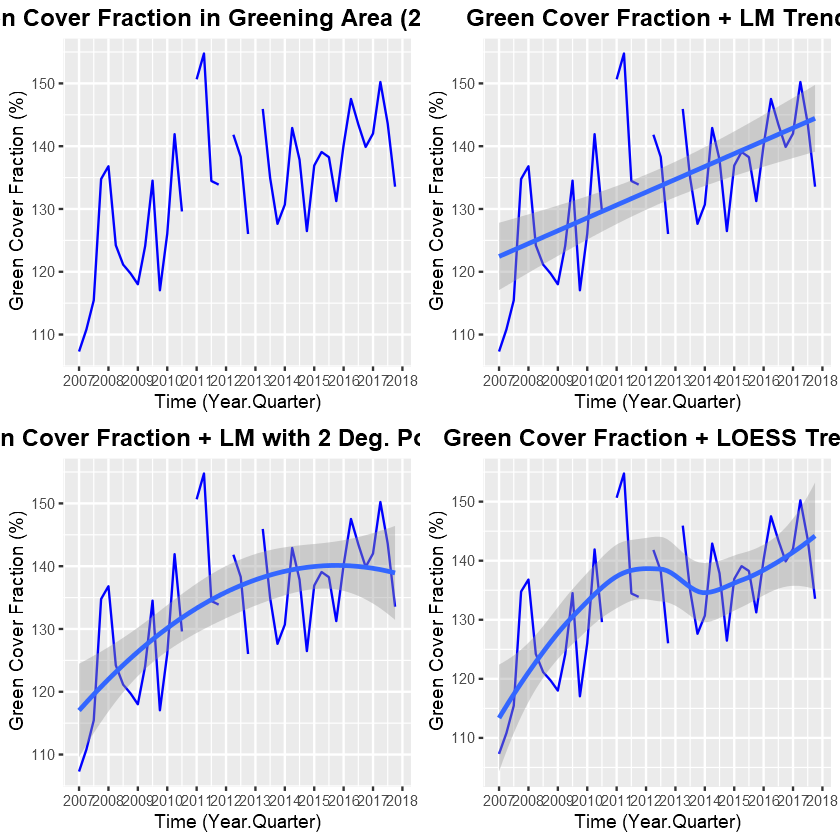

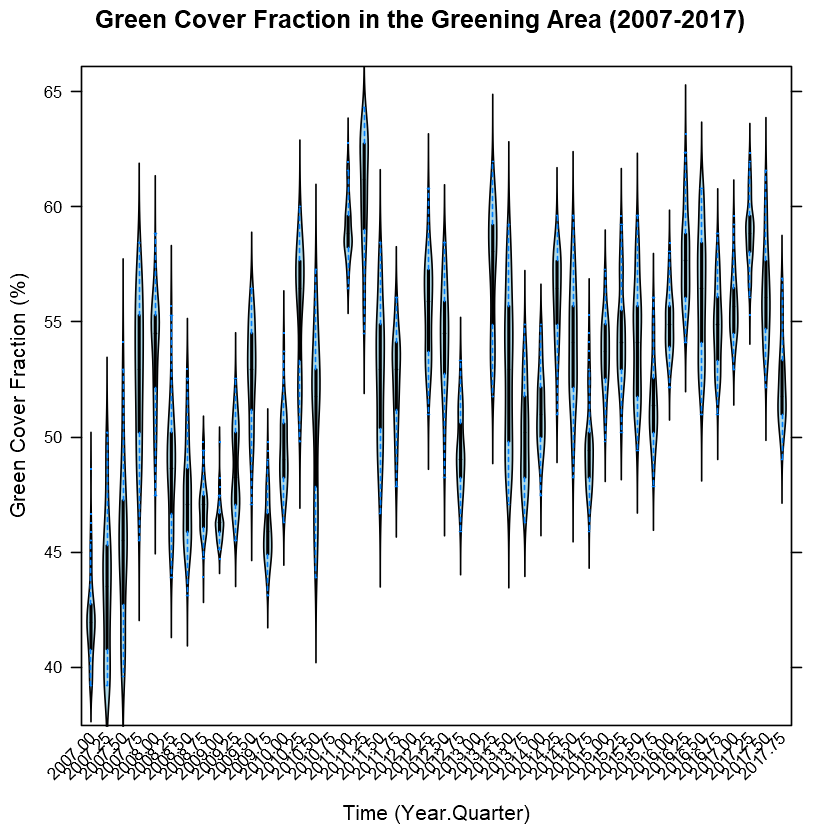

In [13]:

# Scatter-plot (with lines) using different Smooths
# =================================================
# 'ggplot' requires a dataframe, so we first create a dataframe containing the 
# Green Cover Fractions (%) and Times (Years & Quarters).

# Create dataframe
# ----------------
GCF.GA.df = data.frame(Time=GCF.GA.Times, Mean=GCF.GA.Means)
summary(GCF.GA.df)

# Create base plot (base + points)
# --------------------------------
base.p = ggplot(GCF.GA.df, aes(x=Time, y=Mean)) + 
		 theme(plot.title=element_text(hjust = 0.5, size=14, face="bold")) +
		 labs(x="Time (Year.Quarter)", y="Green Cover Fraction (%)")	+ 
		 scale_x_continuous(breaks=2007:2018) +
		 geom_line(color="blue")
#base.p

# Add different types of Smooths to the Base Plot
# -----------------------------------------------

# No Trend
base.NoSmooth.p = base.p + ggtitle("Green Cover Fraction in Greening Area (2007-2017)")
#base.NoSmooth.p

# Linear Model (LM) Fit
base.SmoothLM.p = base.p + ggtitle("Green Cover Fraction + LM Trend") + 
				  stat_smooth(method = "lm", formula = y ~ x, size = 1)
#base.SmoothLM.p

# LM with 2nd Degree Polynomial Fit (using the function 'poly')
base.SmoothPoly2D.p = base.p + 
					  ggtitle("Green Cover Fraction + LM with 2 Deg. Poly. Trend") + 
					  stat_smooth(method = "lm", formula = y ~ poly(x,2), size = 1)
#base.SmoothPoly2D.p

# Logically Weighted Regression (Loess)
base.SmoothLoess.p = base.p + ggtitle("Green Cover Fraction + LOESS Trend") + 
					 stat_smooth(method = "loess", formula = y ~ x, size = 1)
#base.SmoothLoess.p

# Display all Scatter-plots (with Lines) with different types of Smooths
# ----------------------------------------------------------------------
# `grid.arrange` provides multiple plots per page. They look good on screen, 
# but might be too small in the Workshop/Tutorial report. 
grid.arrange(base.NoSmooth.p, base.SmoothLM.p, base.SmoothPoly2D.p, base.SmoothLoess.p,
      			  nrow=2)
#base.NoSmooth.p		# Used if 'grid.arrange' leads to plots too small
#base.SmoothLM.p		# Used if 'grid.arrange' leads to plots too small
#base.SmoothPoly2D.p	# Used if 'grid.arrange' leads to plots too small
#base.SmoothLoess.p	# Used if 'grid.arrange' leads to plots too small


# Violin Plots (Boxplot + Density Plots)
# ======================================
# Rather than using the default tick labels (too long including the Band and Time), we 
# use tick labels including only the Time (Year & Quarter).

bwplot( GreeningArea.rB*100/255, 
        main="Green Cover Fraction in the Greening Area (2007-2017)", 
		    xlab="Time (Year.Quarter)", ylab="Green Cover Fraction (%)", 
		    scales=list(x=list(labels=format(GCF.GA.Times,nsmall=2),rot=45)) )
